# MNIST Multilayer Perceptron

## Code setup

In [1]:
# Suppressing warnings

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Utility imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Keras imports
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# Source imports
from plotting import training_validation_plotter, accuracy_curves_plotter
from weight_alterations import cannot_electroform

# Dataset download
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Importing LaTeX font for plots

!wget -O cmunrm.ttf https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf

fpath = Path('cmunrm.ttf')
font = fm.FontProperties(fname='cmunrm.ttf', size=18)

--2021-09-11 17:19:50--  https://github.com/nicogig/ComputerModern/raw/main/cmunrm.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nicogig/ComputerModern/main/cmunrm.ttf [following]
--2021-09-11 17:19:50--  https://raw.githubusercontent.com/nicogig/ComputerModern/main/cmunrm.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 639132 (624K) [application/octet-stream]
Saving to: ‘cmunrm.ttf’

cmunrm.ttf          100%[===================>] 624.15K  --.-KB/s    in 0.003s  

2021-09-11 17:19:50 (182 MB/s) - ‘cmunrm.ttf’ saved [639132/639132]



## Neural network setup and training

This is the network architecture employed in the *Simulation of Inference Accuracy Using Realistic RRAM Devices* paper. It consists of a feed-forward multilayer perceptron with 784 input neurons (encoding pixel intensities for 28 × 28 pixel MNIST images), two 100-neuron hidden layers, and 10 output neurons (each corresponding to one of the ten digits). The first three layers employ a sigmoid activation function, whilst the output layer makes use of a softmax activation function (which means a cross-entropy error function is then used throughout the learning task). All 60,000 MNIST training images were employed, divided into training and validation sets in a 3:1 ratio, as described in the aforementioned paper.

In [4]:
# Data reshaping

MLP_train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255
MLP_test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255

MLP_train_labels = to_categorical(train_labels)
MLP_test_labels = to_categorical(test_labels)

In [5]:
# Creating a validation set

MLP_validation_data = MLP_train_images[:15000]
MLP_partial_train = MLP_train_images[15000:]

MLP_validation_labels = MLP_train_labels[:15000]
MLP_partial_labels = MLP_train_labels[15000:]

In [6]:
# Model definition

MNIST_MLP = models.Sequential(name="MNIST_MLP")
MNIST_MLP.add(layers.Dense(100, activation="sigmoid", input_shape=(784,), name="MNIST_MLP_L1"))
MNIST_MLP.add(layers.Dense(100, activation="sigmoid", name="MNIST_MLP_L2"))
MNIST_MLP.add(layers.Dense(10, activation="softmax", name="MNIST_MLP_OL"))

MNIST_MLP.summary()

Model: "MNIST_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MNIST_MLP_L1 (Dense)         (None, 100)               78500     
_________________________________________________________________
MNIST_MLP_L2 (Dense)         (None, 100)               10100     
_________________________________________________________________
MNIST_MLP_OL (Dense)         (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Model training and performance

MNIST_MLP.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# # Training without validation set
# MNIST_MLP.fit(MLP_train_images, MLP_train_labels, epochs=10, batch_size=120)
# MLP_test_loss, MLP_test_acc = MNIST_MLP.evaluate(MLP_test_images, MLP_test_labels)
# print("Test accuracy: ", np.round(MLP_test_acc*100, 3), "%")

# Training with validation test
MLP_history = MNIST_MLP.fit(MLP_partial_train, MLP_partial_labels, epochs=10, batch_size=100,
              validation_data=(MLP_validation_data, MLP_validation_labels))
MLP_test_loss, MLP_test_acc = MNIST_MLP.evaluate(MLP_test_images, MLP_test_labels)
print("Test accuracy: ", np.round(MLP_test_acc*100, 3), "%")

# Extracting network weights for alterations carried out in the sections below.
# MLP_weights is a list containing the parameters associated with each layer of the ANN. MLP_weights[0] comprises the weights related to
# the 78,400 synapses between layer 1 and layer 2, MLP_weights[1] contains the bias terms for the 10 neurons in layer 2, and so forth
MLP_weights = MNIST_MLP.get_weights()

Epoch 1/10
450/450 [==============================] - 2s 4ms/step - loss: 1.2467 - accuracy: 0.6952 - val_loss: 0.3326 - val_accuracy: 0.9081
Epoch 2/10
450/450 [==============================] - 1s 3ms/step - loss: 0.2929 - accuracy: 0.9162 - val_loss: 0.2457 - val_accuracy: 0.9279
Epoch 3/10
450/450 [==============================] - 1s 3ms/step - loss: 0.2212 - accuracy: 0.9354 - val_loss: 0.2078 - val_accuracy: 0.9373
Epoch 4/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1868 - accuracy: 0.9439 - val_loss: 0.1786 - val_accuracy: 0.9455
Epoch 5/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1524 - accuracy: 0.9561 - val_loss: 0.1614 - val_accuracy: 0.9507
Epoch 6/10
450/450 [==============================] - 2s 4ms/step - loss: 0.1262 - accuracy: 0.9626 - val_loss: 0.1388 - val_accuracy: 0.9591
Epoch 7/10
450/450 [==============================] - 1s 3ms/step - loss: 0.1124 - accuracy: 0.9669 - val_loss: 0.1277 - val_accuracy: 0.9611
Epoch 

## Performance evolution during training

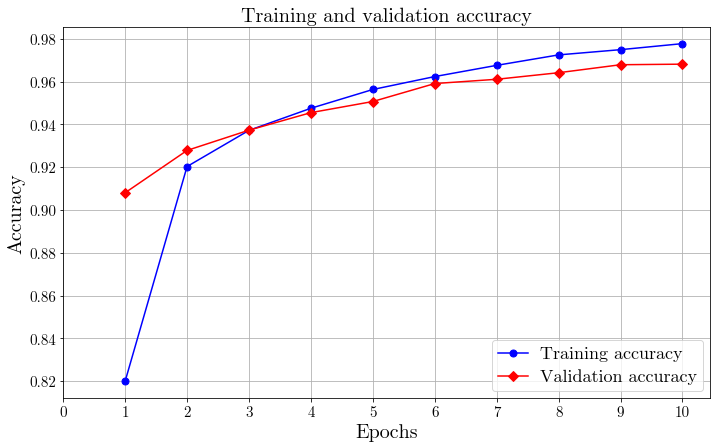

In [8]:
# Plotting training and validation accuracy

history_dict = MLP_history.history

accuracy_values = history_dict["accuracy"]
val_accuracy_values = history_dict["val_accuracy"]
epochs = range(1, len(accuracy_values) + 1)

training_validation_plotter(epochs, accuracy_values, val_accuracy_values, "Accuracy", font)

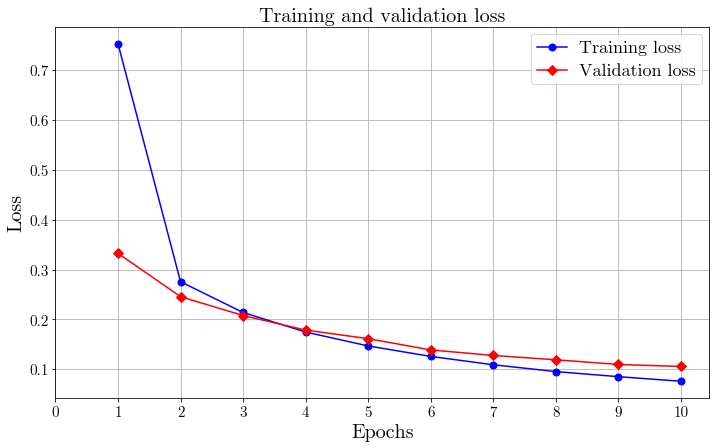

In [9]:
# Plotting training and validation loss

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

training_validation_plotter(epochs, loss_values, val_loss_values, "Loss", font)

## Type I Fault: Cannot electroform

In [19]:
# Setting variable percentages of the ANN's synaptic weights to zero in order to simulate devices being unable to electroform

accuracy = []

for percentage in np.arange(0, 1.01, 0.025):
    altered_weights = cannot_electroform(MLP_weights, percentage)
    



accuracy_curves_plotter(accuracies_list, value_type=1, fpath=None, filename="", labels=[], label_step=10):

# The "set_weights" function sets the ANN's weights to the values specified in the list of arrays "MLP_weights"
MNIST_MLP.set_weights(MLP_weights) 

In [11]:
MLP_test_loss, MLP_test_acc = MNIST_MLP.evaluate(MLP_test_images, MLP_test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.1949 - accuracy: 0.9541


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f63981ff-15e3-4a0a-8bcf-dbdeefafcfde' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>